## Show results - Test 

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
#import palettable (is not working...)
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../src/util')
sys.path.append('../../src/write_entities')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard

from stacked_grouped_barplot import plot_clustered_stacked
from stacked_grouped_barplot_error \
import plot_clustered_stacked_with_error
from define_exposures import call_exposures
from shapefile_masks import vector_shapefile_mask

fig_dir = '../figures/'

2020-07-13 15:27:26,251 - climada - DEBUG - Loading default config file: C:\Users\valen\Documents\GitHub\climada_python\climada\conf\defaults.conf


## Damage cost for each scenario, year and labor type

In [2]:
#First we import and open the pickle file containing a dictionnary of the losses. 
#The dictionnary is a nested dictionnary, with the first layer being the different scenarios, 
#the second the years. For each scenario and each year, there is a panda dataframe 
#with the 2 types of exposures as columns, according to the age of the people (the different exposures).
#The rows of the panda dataframe correspond to the output of each Monte Carlo run.

pickle_in = \
open('../../output/impact_ch/loss_all_age_groups_10mc_all_uncertainties_CH.pickle','rb')
loss_CH= pickle.load(pickle_in)  

# Add a column to each dataframe with the sum of all exposures for each monte carlo.
for s_ in loss_CH:
    for y_ in loss_CH[s_]:     
        loss_CH[s_][y_]['total'] \
        = loss_CH[s_][y_][list(loss_CH[s_][y_].columns)].sum(axis=1)   
        
RCPs = {'RCP26':'RCP2.6','RCP45':'RCP4.5', 'RCP85':'RCP8.5'} #to get the correct name in the plots

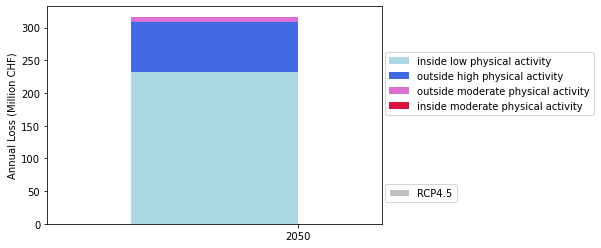

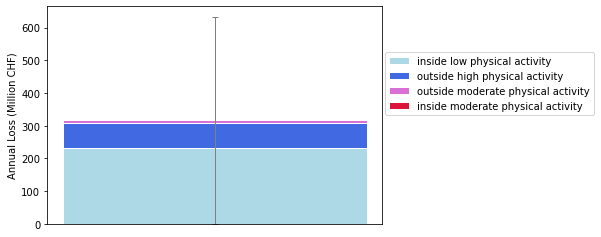

In [3]:
#We make a new dictionnary of the scenarios, with the different types of exposures
#as columns and the years in the rows. Then, the clustered stacked barplots can be called, 
#with the dictionnary of panda median as input, where the rows of each dataframe correspond to the grouping 
#criteria (by year), the columns to the stacks (the age categories) 
#and the dictionnary keys to the hatches (the scenario).  

median = {}
minimums = {}
maximums = {}

for s_ in loss_CH:
    median[RCPs[s_]] = pd.DataFrame()#dataframe containing the median realization for the different exposures
    maximums[RCPs[s_]] = pd.DataFrame() #dataframe containing the 95th percentile realization for the different exposures
    minimums[RCPs[s_]] = pd.DataFrame()#dataframe containing the 5th percentile realization for the different exposures
    
    for y_ in loss_CH[s_]:
        median[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).median())  #don't need the total here 
        maximums[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).quantile(0.95))
        minimums[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).quantile(0.05))
    
    median[RCPs[s_]] = median[RCPs[s_]].transpose()
    maximums[RCPs[s_]] = maximums[RCPs[s_]].transpose()
    minimums[RCPs[s_]] = minimums[RCPs[s_]].transpose()

fig, ax = plt.subplots()
plot_clustered_stacked(median,title = '',color= ['lightblue','royalblue'])
plt.ylabel('Annual Heat-related Deaths [#]')
ax.ticklabel_format(style='plain')

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065.pdf']),bbox_inches='tight')

fig, ax = plt.subplots()
plot_clustered_stacked_with_error(median,minimums,maximums,color= ['lightblue','royalblue'])
plt.ylabel('Annual Heat-related Deaths [#]')

#plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2065_werror.pdf']),bbox_inches='tight')


## Spatial Impact

In [4]:
#we now open the matrice output which is a three level nested dictionnary with a csr matrix at the end.
#There is one matrix for each combination of scenario, year and exposure type.
#Each matrix corresponds to the median of all the monte carlos for each exposure.

pickle_in = open('../../output/impact_ch/matrix_all_age_groups_10mc_all_uncertainties_CH.pickle','rb')
matrices = pickle.load(pickle_in)

In [5]:
#we call the exposures to be able to calculate the percentage lossed

directory_exposures          = '../../input_data/exposures/'
exposures   = call_exposures()
for e_ in exposures: # get the yearly value of the exposures, as the exposures from call_exposures() are daily values
    exposures[e_].value = exposures[e_].value*365 # 365 days per year

2020-07-13 15:27:38,312 - climada.util.coordinates - INFO - Setting geometry points.
2020-07-13 15:27:47,838 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-07-13 15:27:47,840 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-07-13 15:27:47,845 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-07-13 15:27:47,847 - climada.entity.exposures.base - INFO - centr_ not set.
2020-07-13 15:27:47,848 - climada.entity.exposures.base - INFO - deductible not set.
2020-07-13 15:27:47,849 - climada.entity.exposures.base - INFO - cover not set.
2020-07-13 15:27:47,850 - climada.entity.exposures.base - INFO - category_id not set.
2020-07-13 15:27:47,851 - climada.entity.exposures.base - INFO - region_id not set.
2020-07-13 15:27:55,333 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-07-13 15:28:00,124 - climada.util.coordinates -

In [6]:
#rewrite impacts from impact matrix

median_impact_2050_RCP45_under75 = Impact()
median_impact_2050_RCP45_under75.coord_exp =\
np.stack([exposures['Under 75 years'].latitude.values,exposures['Under 75 years'].\
          longitude.values], axis=1)
median_impact_2050_RCP45_under75.event_id = np.array([1])
median_impact_2050_RCP45_under75.imp_mat =\
csr_matrix((csr_matrix(matrices['RCP45']['2050']['Under 75 years']).toarray()[0,:]\
            /exposures['Under 75 years'].value.replace(0, 1))*100) #put impacts in terms of percentage of exposure
median_impact_2050_RCP45_under75.unit = '%'

median_impact_2050_RCP45_over75 = Impact()
median_impact_2050_RCP45_over75.coord_exp =\
np.stack([exposures['Over 75 years'].latitude.values,exposures['Over 75 years']\
          .longitude.values], axis=1)
median_impact_2050_RCP45_over75.event_id = np.array([1])
median_impact_2050_RCP45_over75.imp_mat =\
csr_matrix((csr_matrix(matrices['RCP45']['2050']['Over 75 years']).toarray()[0,:]\
            /exposures['Over 75 years'].value.replace(0, 1))*100)
median_impact_2050_RCP45_over75.unit = '%'

C:\Users\valen\Documents\GitHub\climada_python\climada\util\plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
C:\Users\valen\.conda\envs\climada_env\lib\site-packages\cartopy\mpl\feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))
C:\Users\valen\.conda\envs\climada_env\lib\site-packages\cartopy\mpl\feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))
C:\Users\valen\Documents\GitHub\climada_python\climada\util\plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
C:\Users\valen\.conda\envs\climada_env\lib\site-packages

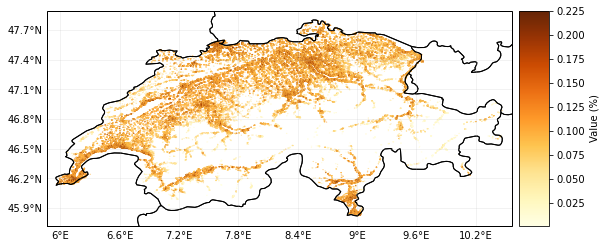

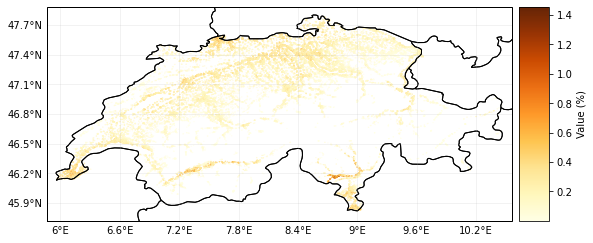

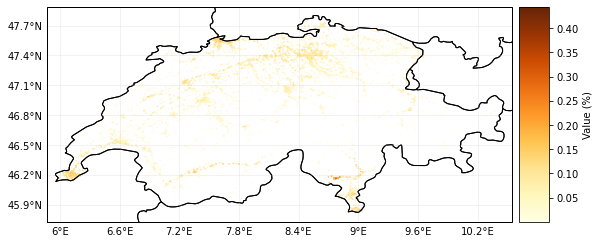

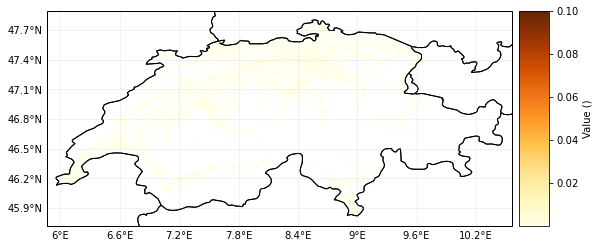

In [7]:
#cm= palettable.scientific.sequential.LaJolla_20.mpl_colormap (is not working...)
cm = 'YlOrBr'

#plot the impact as a percentage of the total exposures value
median_impact_2050_RCP45_under75.plot_hexbin_impact_exposure(pop_name = False,cmap=cm,buffer=0.1)
#plt.savefig(''.join([fig_dir,'loss_ch/ch','_map_under75_percentage.pdf']),bbox_inches='tight')

median_impact_2050_RCP45_over75.plot_hexbin_impact_exposure(pop_name = False,cmap=cm,buffer=0.1)
#plt.savefig(''.join([fig_dir,'loss_ch/ch','_map_over75_percentage.pdf']),bbox_inches='tight')